# Evaluation of the issues in "Dissecting cell identity via network inference and in silico gene perturbation"
### by Jalil Nourisa
In the 2023 Nature publication "Dissecting cell identity via network inference and in silico gene perturbation", the authors introduced CellOracle (CO), a novel method leveraging mRNA-seq and ATAC-seq data to construct gene regulatory networks (GRNs), which are subsequently used for gene perturbation. They designed CO to account for the role of distal cis-regulatory elements, e.g. enhancers, as well as proximal promoters in the gene regulation system. For this purpose, they employed Cicero to determine the co-accessibility scores between peaks, provided by ATAC-seq data. These scores are then used to identify the interaction of distal regions with the target gene. Using Cicero, they have conducted multiple perturbation studies on different organisms and identified novel phenotypes resulting from transcriptional factor (TF) perturbation. In addition, they benchmarked CO's performance using ChIP-seq data as ground truth against other state-of-the-art GRN methods across multiple mouse tissue samples. However, our evaluation reveals critical limitations in the implementation of their methodology, both in terms of ATAC-seq data integration as well as benchmarking. In this report, we first explain the limitations in their approach of integrating ATAC-seq data. We show that the proposed algorithm fails to account for distal regulatory interactions. After, we present the issues associated with their benchmarking algorithm and the data used for benchmarking. We show that their findings regarding the comparative performance of CO against other GRN inference methods is invalid and requires further evaluation. 

This notebook provides the analysis code.



Install the package from the main directory `pip install .`

In [33]:
import os
import pandas as pd
from celloracle import motif_analysis as ma
import numpy as np
%matplotlib inline

# Integration of ATAC-seq data


## Steps taken by the CO in integrating proximal and distal cis-regulatory elements
The data and code of this section is directly taken from the original tutorial [https://github.com/morris-lab/CellOracle/blob/master/docs/notebooks/01_ATAC-seq_data_processing/option1_scATAC-seq_data_analysis_with_cicero/02_preprocess_peak_data.ipynb]. Find the details of each method there.

### Download two processed files of all_peaks and cicero_connections.

In [57]:
# Download file. 
!wget https://raw.githubusercontent.com/morris-lab/CellOracle/master/docs/demo_data/all_peaks.csv
!wget https://raw.githubusercontent.com/morris-lab/CellOracle/master/docs/demo_data/cicero_connections.csv

--2024-01-17 13:23:20--  https://raw.githubusercontent.com/morris-lab/CellOracle/master/docs/demo_data/all_peaks.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2940392 (2.8M) [text/plain]
Saving to: ‘all_peaks.csv.1’

all_peaks.csv.1     100%[===================>]   2.80M   822KB/s    in 3.5s    

2024-01-17 13:23:25 (822 KB/s) - ‘all_peaks.csv.1’ saved [2940392/2940392]

--2024-01-17 13:23:25--  https://raw.githubusercontent.com/morris-lab/CellOracle/master/docs/demo_data/cicero_connections.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response.

In [2]:
# Load scATAC-seq peak list.
peaks = pd.read_csv("all_peaks.csv", index_col=0)
peaks = peaks.x.values
print(len(peaks))
# Load Cicero coaccessibility scores.
cicero_connections = pd.read_csv("cicero_connections.csv", index_col=0)
cicero_connections.head()

/root/anaconda3/envs/celloracle/lib/python3.10/site-packages/loompy/bus_file.py:68: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def twobit_to_dna(twobit: int, size: int) -> str:
/root/anaconda3/envs/celloracle/lib/python3.10/site-packages/loompy/bus_file.py:85: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def dna_to_twobit(dna: str) -> int:
/root/anaconda3/en

86935


,Peak1,Peak2,coaccess
1,chr10_100006139_100006389,chr10_99774288_99774570,-0.003546
2,chr10_100006139_100006389,chr10_99825945_99826237,-0.027536
3,chr10_100006139_100006389,chr10_99830012_99830311,0.009588
4,chr10_100006139_100006389,chr10_99833211_99833540,-0.008067
5,chr10_100006139_100006389,chr10_99941805_99941955,0.000000


In [3]:
peaks_split = [peak.split('_') for peak in peaks]
peaks_width = [np.abs(int(peak[2])-int(peak[1])) for peak in peaks_split]
np.mean(peaks_width)

783.3805946971876

### Annotate transcription start sites (TSSs)

In [12]:
##!! Please make sure to specify the correct reference genome here
tss_annotated = ma.get_tss_info(peak_str_list=peaks, ref_genome="mm10") 

# Check results
tss_annotated.tail()

que bed peaks: 86935
tss peaks in que: 17238


,chr,start,end,gene_short_name,strand
17233,chr1,55130650,55132118,Mob4,+
17234,chr6,94499875,94500767,Slc25a26,+
17235,chr19,45659222,45660823,Fbxw4,-
17236,chr12,100898848,100899597,Gpr68,-
17237,chr4,129491262,129492047,Fam229a,-


### Integrate TSS info and cicero connections

In [13]:
integrated = ma.integrate_tss_peak_with_cicero(tss_peak=tss_annotated, 
                                               cicero_connections=cicero_connections)
print(integrated.shape)
integrated.head()

(44309, 3)


,peak_id,gene_short_name,coaccess
0,chr10_100006139_100006389,Tmtc3,0.017915
1,chr10_100015291_100017830,Kitl,1.000000
2,chr10_100018677_100020384,Kitl,0.146517
3,chr10_100050858_100051762,Kitl,0.069751
4,chr10_100052829_100053395,Kitl,0.202670


### Filter peaks

In [14]:
peak = integrated[integrated.coaccess >= 0.8]
peak = peak[["peak_id", "gene_short_name"]].reset_index(drop=True)
len(peak)

15779

## Evaluation of the obtained results
The shortlisted peak gives the final draft of peak-gene list, which intends to incorporate both proximal and distal cis-regulatory interactions.In this section, we evaluate to what extend CO achieves this purpose. 

In [16]:
# convert peak to peak_id using celloracle function
tss_annotated_df = pd.DataFrame({"peak_id": ma.process_bed_file.df_to_list_peakstr(tss_annotated),
                            "gene_short_name": tss_annotated.gene_short_name.values})
tss_annotated_df

,peak_id,gene_short_name
0,chr12_102756584_102758754,Ubr7
1,chr17_24168504_24170171,Atp6v0c-ps2
2,chr14_30950721_30952050,Nek4
3,chr8_95330916_95332867,Usb1
4,chr7_120981332_120983142,Cdr2
...,...,...
17233,chr1_55130650_55132118,Mob4
17234,chr6_94499875_94500767,Slc25a26
17235,chr19_45659222_45660823,Fbxw4
17236,chr12_100898848_100899597,Gpr68


First, we evaluate the composition of the shortlisted peak gene pairs. We check what percentage of these pairs are taken from tss_annotated which are the list of proximal interactions.

In [17]:
# number of tss_annotated pairs in shortlisted peak
print(f'Percentage of proximal elements in the final peak gene pairs: {100*peak.peak_id.isin(tss_annotated_df.peak_id).sum()/len(peak)}')

Percentage of proximal elements in the final peak gene pairs: 100.0


we observe that all of the pairs belong to the proximal elements. Let's check what would be the lowest co-access score to include non proximal elements.

In [23]:
# minimum threshold to include distal cis-reg interactions 
integrated_tss = pd.merge(integrated, tss_annotated_df, on=['peak_id','gene_short_name'], how='outer', indicator=True) 
non_tss_pairs = integrated_tss[integrated_tss._merge=='left_only']
non_tss_pairs.coaccess.max()


0.798350891632171

next, we evaluate the domain of regulatory chromatin (DORC), which is number of peaks per gene in the connections.

In [27]:
dorc_shortlisted = peak.groupby('gene_short_name').size()
dorc_all = integrated.groupby('gene_short_name').size()

In [28]:
print(f"In the short list: max peaks per gene: {dorc_shortlisted.max()}, median: {dorc_shortlisted.median()}")
print(f"In the complete list: max peaks per gene: {dorc_all.max()}, median: {dorc_all.median()}")

In the short list: max peaks per gene: 6, median: 1.0
In the complete list: max peaks per gene: 75, median: 1.0


by different cut-off thresholds, lets see the number of DORCs.

# Benchmarking algorithm, data, and results

## Benchmarking data
The authors have provide the data required to reproduce the benchmarkiung results presented in the paper. To run the code, we first download the data from this link, unzip it, and place it in data_dir directory. 

https://drive.google.com/file/d/17C9-PNcroDtFycnMBxoNNjbEk1Fcwo_X/view?usp=drive_link

## Evaluation of the original implementation of the benchmarking method

### Calculate benchmarking scores using CO original implementation implementation
By passing the flag --benchmark-method CO, the code runs the original code.

In [ ]:
data_dir = f'../external' # set this to the right location wbere the downloaded data are located
os.makedirs(data_dir, exist_ok=True)

In [1]:
%run ../CO_evaluation/post_GRN/calculate_scores_CO.py --benchmark-method CO --verbose --data_dir {data_dir}

output -> /mnt/c/Users/nourisa/Documents/testProjs/ongoing/CO_evaluation/results/CO/benchmark/scores_CO/figures/auc.png
output -> /mnt/c/Users/nourisa/Documents/testProjs/ongoing/CO_evaluation/results/CO/benchmark/scores_CO/figures/epr.png


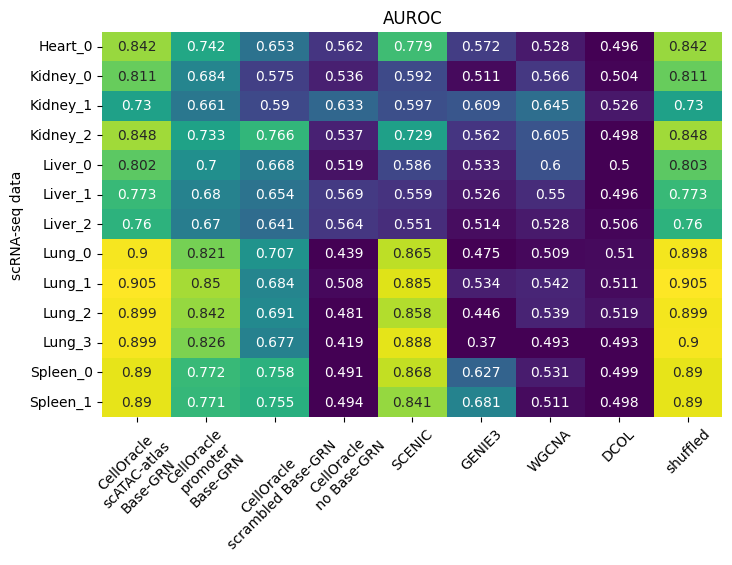

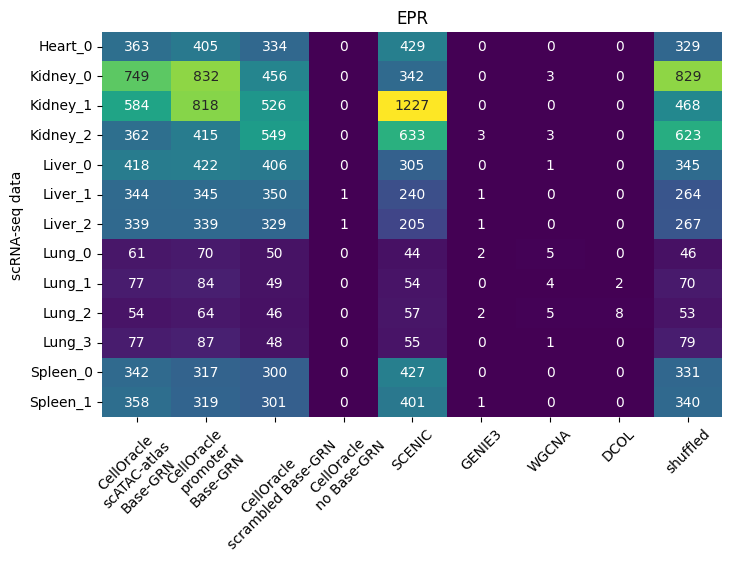

In [ ]:
%run ../CO_evaluation/post_GRN/plot_scores.py --verbose --benchmark-method CO

### Calculate the stats of class misbalance in the case of the original imeplentation

output -> /mnt/c/Users/nourisa/Documents/testProjs/ongoing/CO_evaluation/results/CO/benchmark/stats/plot_CO.png
output -> /mnt/c/Users/nourisa/Documents/testProjs/ongoing/CO_evaluation/results/CO/benchmark/stats/plot_CO_GT_TFs.png


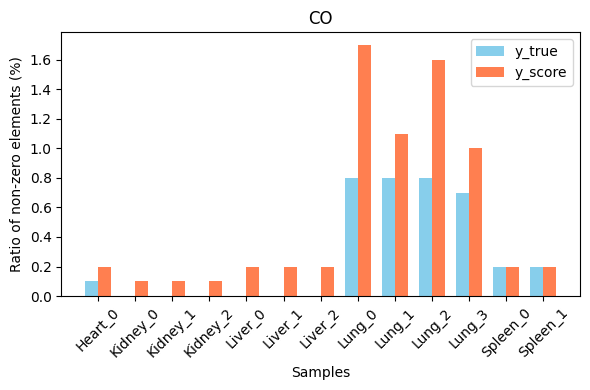

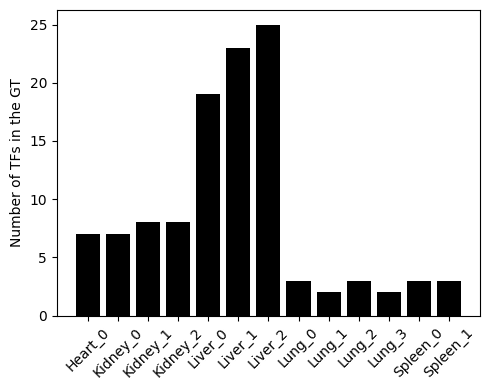

In [ ]:
# calculate and show the significane of class misbalance in the original implementation of CO 
%run ../CO_evaluation/post_GRN/plot_benchmarking_stats.py --benchmark-method CO --verbose

## Fixing the issues in the implementation of the benchmarking method

### Calculate benchmarking scores using the fixed implementation


auc_random
auc_pr_random
f1_random
output -> /mnt/c/Users/nourisa/Documents/testProjs/ongoing/CO_evaluation/results/CO/benchmark/scores_M1/figures/auc.png
output -> /mnt/c/Users/nourisa/Documents/testProjs/ongoing/CO_evaluation/results/CO/benchmark/scores_M1/figures/epr.png
output -> /mnt/c/Users/nourisa/Documents/testProjs/ongoing/CO_evaluation/results/CO/benchmark/scores_M1/figures/auc_pr.png
output -> /mnt/c/Users/nourisa/Documents/testProjs/ongoing/CO_evaluation/results/CO/benchmark/scores_M1/figures/f1.png


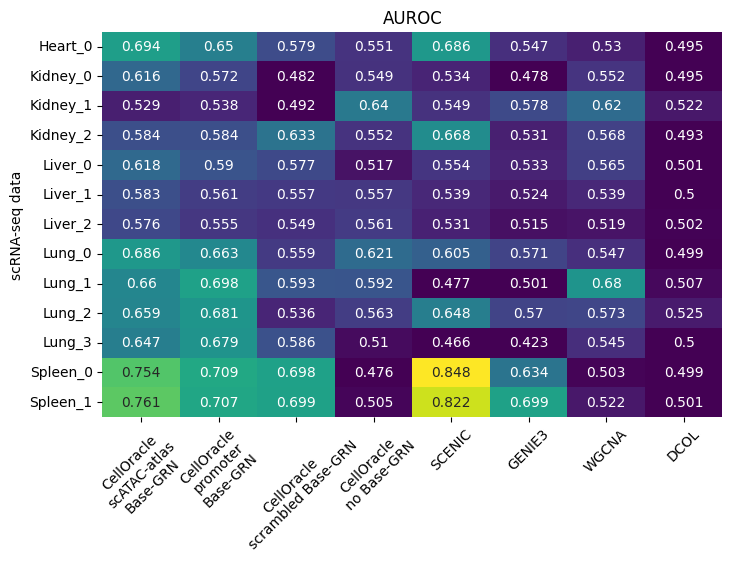

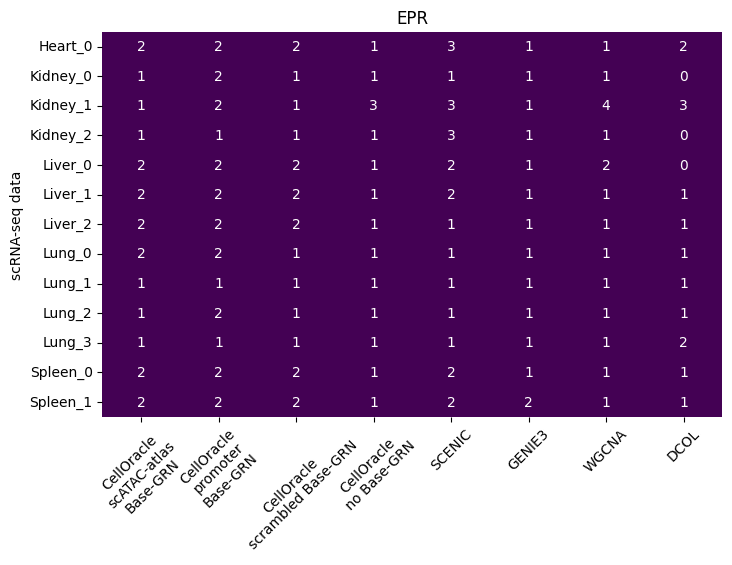

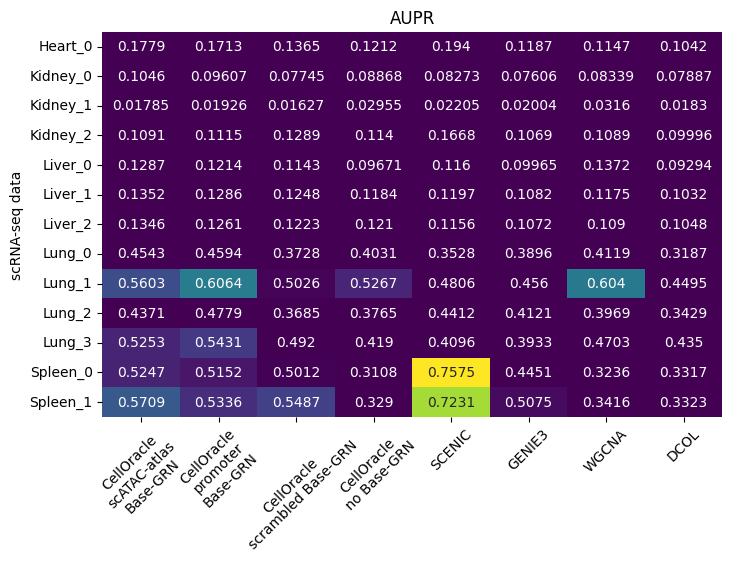

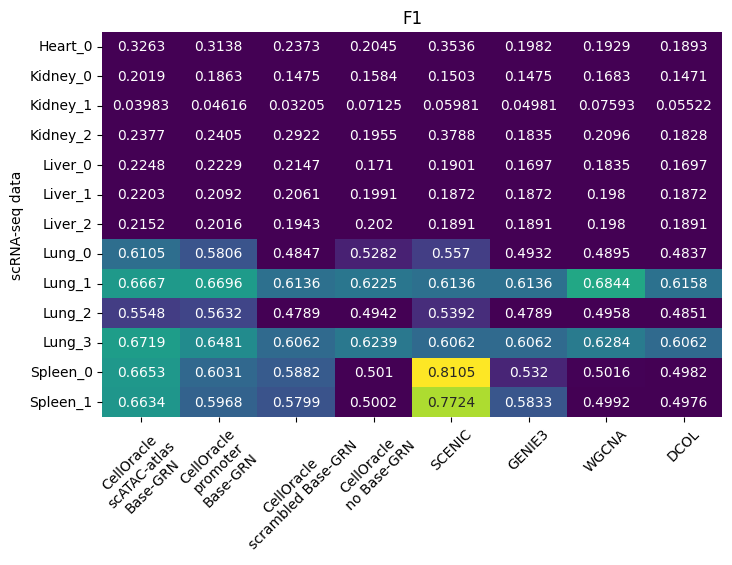

In [ ]:
# calculate benchmarking scores using the fixed formulation: M1
%run ../CO_evaluation/post_GRN/calculate_scores_CO.py --benchmark-method M1 --verbose 
# plot the scores 
%run ../CO_evaluation/post_GRN/plot_scores.py --verbose --benchmark-method M1

### Calculate the stats of class misbalance in the case of the alternative imeplentation

output -> /mnt/c/Users/nourisa/Documents/testProjs/ongoing/CO_evaluation/results/CO/benchmark/stats/plot_M1.png
output -> /mnt/c/Users/nourisa/Documents/testProjs/ongoing/CO_evaluation/results/CO/benchmark/stats/plot_M1_GT_TFs.png


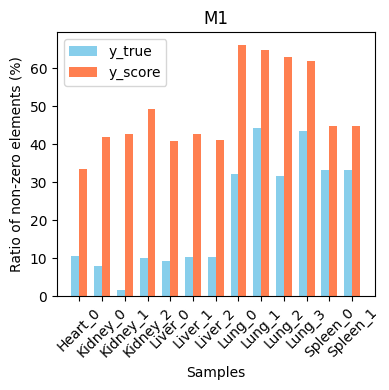

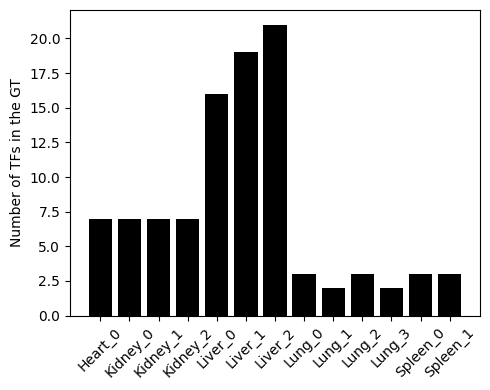

In [ ]:
# Show the class misbalance stats for the alternative implementation
%run ../CO_evaluation/post_GRN/plot_benchmarking_stats.py --benchmark-method M1 --verbose

## Evaluation of the additive value of the regression based GRN inference over the base GRN

auc_random
auc_pr_random
f1_random
output -> /mnt/c/Users/nourisa/Documents/testProjs/ongoing/CO_evaluation/results/CO/benchmark/scores_M1/figures/auc.png
output -> /mnt/c/Users/nourisa/Documents/testProjs/ongoing/CO_evaluation/results/CO/benchmark/scores_M1/figures/epr.png
output -> /mnt/c/Users/nourisa/Documents/testProjs/ongoing/CO_evaluation/results/CO/benchmark/scores_M1/figures/auc_pr.png
output -> /mnt/c/Users/nourisa/Documents/testProjs/ongoing/CO_evaluation/results/CO/benchmark/scores_M1/figures/f1.png


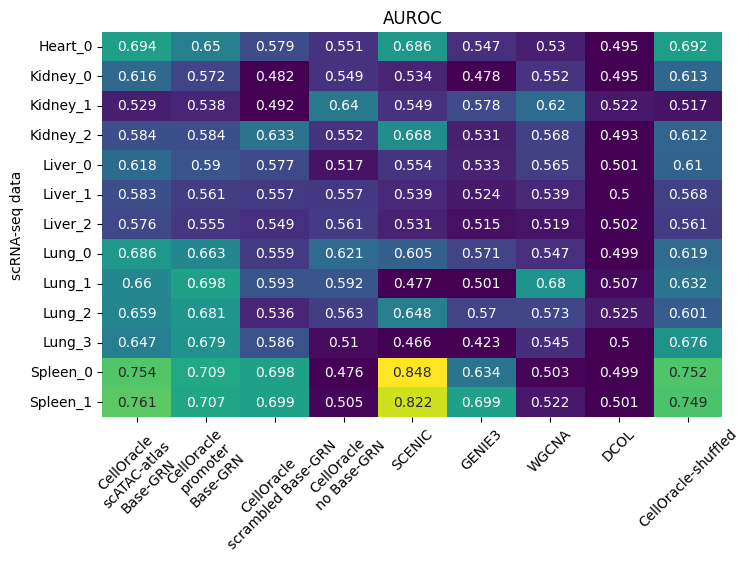

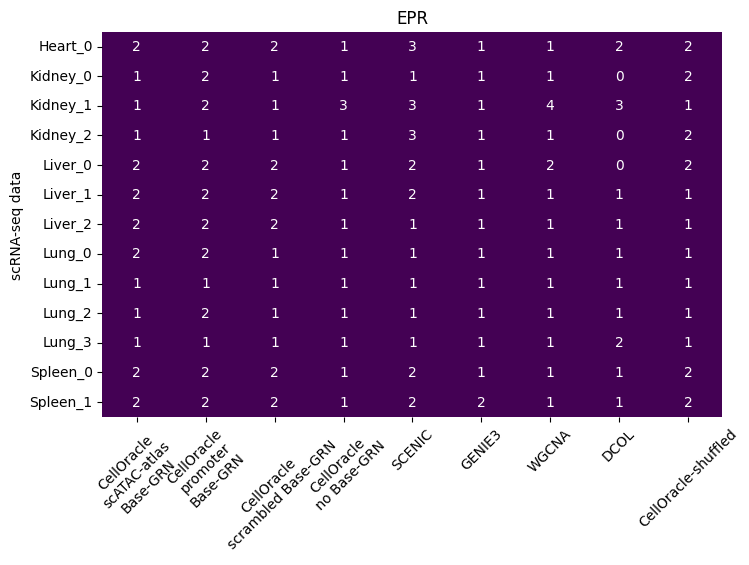

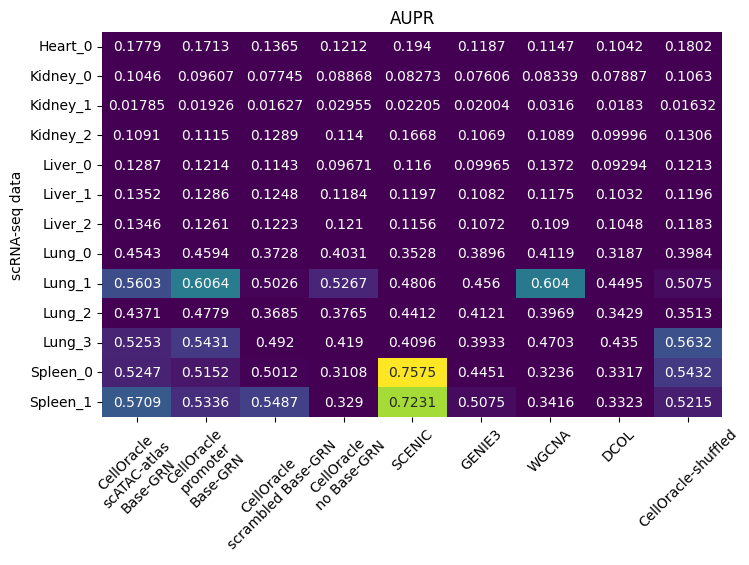

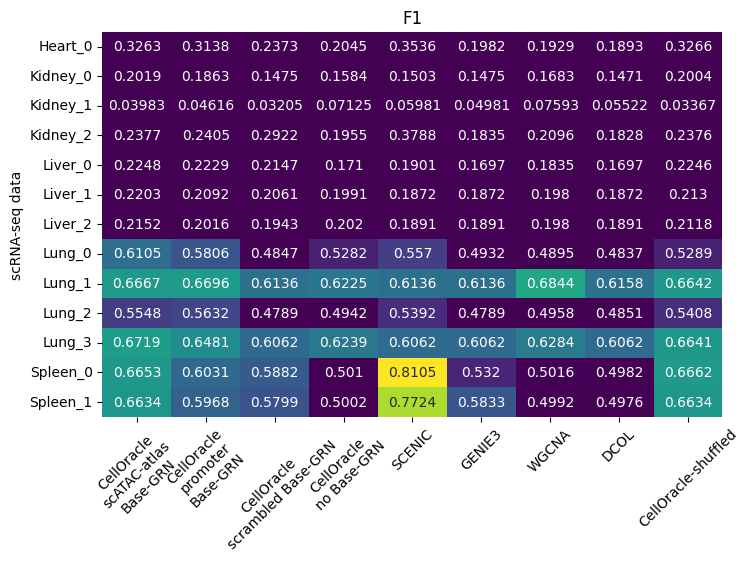

In [ ]:
# calculate benchmarking scores for shuffled GRN values
%run ../CO_evaluation/post_GRN/calculate_scores_CO.py --benchmark-method M1 --shuffle --verbose 
# plot the scores 
%run ../CO_evaluation/post_GRN/plot_scores.py --verbose --benchmark-method M1

### Mean score across different samples for shuffled and inferred values

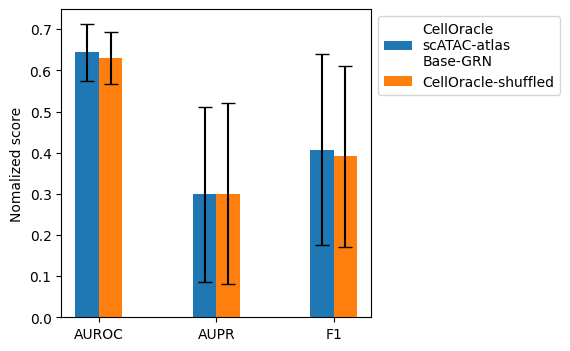

In [ ]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt

# Given lists to store data
methods = ['CellOracle\nscATAC-atlas\nBase-GRN', 'shuffled']
metrics = ['auc', 'auc_pr', 'f1']
means = []
stds = []

# Assuming 'M1' is the only benchmark method we are evaluating
benchmark_method = 'M1'
SCORES_DIR = f'../results/CO/benchmark/scores_{benchmark_method}'

# Collecting the mean and standard deviation for each method and metric
for metric in metrics:
    df = pd.read_csv(f'{SCORES_DIR}/scores_all_{metric}.csv', index_col=0)
    # if metric in ['auc_pr', 'f1', 'auc']:  # Normalize if needed
    #     baseline = pd.read_csv(f'{SCORES_DIR}/scores_all_{metric}_random.csv', index_col=0)
    #     df = df / baseline
    means.append(df.mean().values)
    stds.append(df.std().values)

# Convert lists to numpy arrays
means = np.array(means)
stds = np.array(stds)

# Plotting
positions = np.arange(len(metrics))
width = 0.2

fig, ax = plt.subplots(figsize=(4,4))

for i, method in enumerate(methods):
    if method=='shuffled':
        method = 'CellOracle-shuffled'
    ax.bar(positions - width/2 + i * width, means[:, i], width, yerr=stds[:, i], 
           label=method, capsize=5)
ax.set_ylabel('Nomalized score')
# ax.set_title('Scores by metric and method')
ax.set_xticks(positions)
ax.set_xticklabels([ 'AUROC',  'AUPR', 'F1'])
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.show()


In [ ]:
import scipy
for metric in metrics:
    df = pd.read_csv(f'{SCORES_DIR}/scores_all_{metric}.csv', index_col=0)

    method_1 = df['CellOracle\nscATAC-atlas\nBase-GRN'].values
    method_2 = df['shuffled'].values

    print(metric, scipy.stats.ttest_ind(method_1, method_2))

auc TtestResult(statistic=0.4725634338333972, pvalue=0.6407937893405176, df=24.0)
auc_pr TtestResult(statistic=0.19254100644030384, pvalue=0.8489384258277135, df=24.0)
f1 TtestResult(statistic=0.10488344709741272, pvalue=0.9173399346743567, df=24.0)


## Evaluation of the benchmarking data in terms of TFs count per tissue

In [ ]:
import pandas as pd
import numpy as np
from CO_evaluation.imports import tissues
tfs_alltissues = []
for tissue in tissues:
    df= pd.read_csv(f"{data_dir}/celloracle_grn_benchmark/data/ground_truth_data/chip_atlas/data/{tissue}/chip_GT_links.csv", index_col=0)
    tfs_alltissues.append(df.tf.unique())

In [ ]:
flattened_list = [item for sublist in tfs_alltissues for item in sublist]
np.shape(flattened_list)

(60,)